# Produces heatmaps of counts as a function of anode voltage and pressure, truncating data below the breakdown voltage. Also creates plots of VB against tube pressure for both left and right tubes

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl

## Loading Counts data and VB data

In [2]:
#pressure and breakdown voltage data
VBData = pd.read_csv('Vb.csv')
VBPressure = VBData['Pressure'].to_list()
VBL = VBData['VBL'].to_list()
VBR = VBData['VBR'].to_list()

#directory which contains the scans
directory = 'GMTubeScans'

#columns for the dataframes
cols = ['Anode', 'Pressure', 'Counts']

#dataframs for left and right tubes
RGM, LGM = pd.DataFrame(columns=cols), pd.DataFrame(columns=cols)

# left tube
for filename in os.listdir(directory):
    filename = directory+'/'+filename
    pressure, voltage, counts, countsOff, current = [], [], [], [], []

    Ldata = pd.read_csv(filename, usecols=([6, 25, 28, 30]), header=6, delimiter='\t')
    Ldata = Ldata.sort_values(by='en')

    idx = VBPressure.index(float(filename[12:16]))
    VB = VBL[idx]

    for i in range(len(Ldata)):
        if int(Ldata['en'][i]) == 0:
            countsOff.append(Ldata['gm1'][i])
        else:
            if Ldata['vb'][i] <= VB:
                current.append(abs(1.0e6*float(Ldata['6487c'][i])))
                voltage.append(Ldata['vb'][i])
                pressure.append(float(filename[12:16]))
                if float(filename[12:16]) < 3.82:
                    counts.append(int(Ldata['gm1'][i]/30))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/30 
                elif 3.82 <= float(filename[12:16]) < 4.8:
                    counts.append(int(Ldata['gm1'][i]/15))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/15
                else: 
                    counts.append(int(Ldata['gm1'][i]/5))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/5
      
    for i in range(len(counts)):
        counts[i] = (counts[i]-countsOff[i])/current[i]

    Ltube = pd.DataFrame(data=list(zip(voltage, pressure, counts)), columns=cols)
    LGM = pd.concat((LGM, Ltube), ignore_index=True)

# right tube
for filename in os.listdir(directory):
    filename = directory+'/'+filename

    pressure, voltage, counts, countsOff, current = [], [], [], [], []

    Rdata = pd.read_csv(filename, usecols=([6, 24, 27, 30]), header=6, delimiter='\t')
    Rdata = Rdata.sort_values(by='en')

    idx = VBPressure.index(float(filename[12:16]))
    VB = VBR[idx]

    for i in range(len(Rdata)):
        if int(Rdata['en'][i]) == 0:
            if Rdata['va'][i] <= 550 and Rdata['gm2'][i] > 1000:
                countsOff.append(0)
            else:
                countsOff.append(Rdata['gm2'][i])
        else:
            if Rdata['va'][i] <= VB:
                pressure.append(float(filename[12:16]))
                current.append(abs(1.0e6*float(Rdata['6487c'][i])))
                voltage.append(Rdata['va'][i])
                if float(filename[12:16]) < 3.82:
                    if Rdata['va'][i] <= 550 and Rdata['gm2'][i] > 1000:
                        counts.append(0)
                    else:
                        counts.append(int(Rdata['gm2'][i]/30))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/30 
                elif 3.82 <= float(filename[12:16]) < 4.8:
                    if Rdata['va'][i] <= 550 and Rdata['gm2'][i] > 1000:
                        counts.append(0)
                    else:
                        counts.append(int(Rdata['gm2'][i]/15))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/15
                else:
                    if Rdata['va'][i] <= 550 and Rdata['gm2'][i] > 1000:
                        counts.append(0)
                    else: 
                        counts.append(int(Rdata['gm2'][i]/5))
                    for j in range(len(countsOff)):
                        countsOff[j] = countsOff[j]/5

    for i in range(len(counts)):
        counts[i] = (counts[i]-countsOff[i])/current[i]

    Rtube = pd.DataFrame(data=list(zip(voltage, pressure, counts)), columns=cols)
    RGM = pd.concat((RGM, Rtube), ignore_index=True)

## Creating Heatmaps

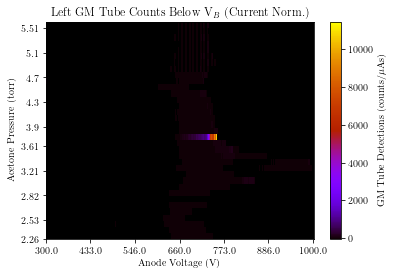

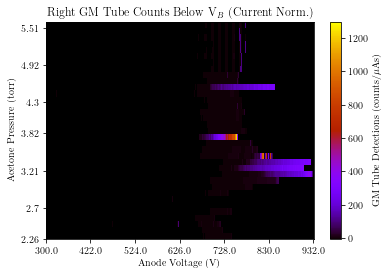

In [3]:
# left tube

LGMPlot = pd.DataFrame(columns=np.unique(LGM['Anode']), index=np.unique(LGM['Pressure'])) # reshapes the data in order to create a heatmap

for i in range(len(LGM['Pressure'])):
    LGMPlot.loc[LGM['Pressure'][i], LGM['Anode'][i]] = float(LGM['Counts'][i])


LGMPlot = LGMPlot.fillna(0.)

fig1, ax1 = plt.subplots()
ax1.pcolormesh(LGMPlot, cmap='gnuplot', vmin=-1/256*max(LGM['Counts']), vmax=max(LGM['Counts']))

ax1.yaxis.set_ticks(np.linspace(0, len(LGMPlot.index)-1, 10, dtype='int'))
ylabels = []
for i in np.linspace(0, len(LGMPlot.index)-1, 10, dtype='int'):
    ylabels.append(LGMPlot.index[i])
ax1.yaxis.set_ticklabels(ylabels)
ax1.set_ylabel('Acetone Pressure (torr)')

ax1.xaxis.set_ticks(np.linspace(0, len(LGMPlot.columns)-1, 7, dtype='int'))
xlabels = []
for i in np.linspace(0, len(LGMPlot.columns)-1, 7, dtype='int'):
    xlabels.append(LGMPlot.columns[i])
ax1.xaxis.set_ticklabels(xlabels)
ax1.set_xlabel('Anode Voltage (V)')

ax1.set_title('Left GM Tube Counts Below V$_B$ (Current Norm.)')

cbar1 = fig1.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1/256*max(LGM['Counts']), vmax=max(LGM['Counts'])), cmap='gnuplot'))
cbar1.set_label('GM Tube Detections (counts/$\mu$As)')
fig1.savefig('Plots/LGMFinalNorm.jpg', dpi=500)
plt.show()

# right tube

RGMPlot = pd.DataFrame(columns=np.unique(RGM['Anode']), index=np.unique(RGM['Pressure'])) # reshapes the data in order to create a heatmap

for i in range(len(RGM['Pressure'])):
    RGMPlot.loc[RGM['Pressure'][i], RGM['Anode'][i]] = float(RGM['Counts'][i])

RGMPlot = RGMPlot.fillna(0.)

fig2, ax2 = plt.subplots()
ax2.pcolormesh(RGMPlot, cmap='gnuplot', vmin=-1/256*max(RGM['Counts']), vmax=max(RGM['Counts']))

ax2.yaxis.set_ticks(np.linspace(0, len(RGMPlot.index)-1, 7, dtype='int'))
ylabels = []
for i in np.linspace(0, len(RGMPlot.index)-1, 7, dtype='int'):
    ylabels.append(RGMPlot.index[i])
ax2.yaxis.set_ticklabels(ylabels)
ax2.set_ylabel('Acetone Pressure (torr)')

ax2.xaxis.set_ticks(np.linspace(0, len(RGMPlot.columns)-1, 7, dtype='int'))
xlabels = []
for i in np.linspace(0, len(RGMPlot.columns)-1, 7, dtype='int'):
    xlabels.append(RGMPlot.columns[i])
ax2.xaxis.set_ticklabels(xlabels)
ax2.set_xlabel('Anode Voltage (V)')

ax2.set_title('Right GM Tube Counts Below V$_B$ (Current Norm.)')

cbar2 = fig2.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-1/256*max(RGM['Counts']), vmax=max(RGM['Counts'])), cmap='gnuplot'))
cbar2.set_label('GM Tube Detections (counts/$\mu$As)')
fig2.savefig('Plots/RGMFinalNorm.jpg', dpi=500)
plt.show()

## Creating Waterfall Plots

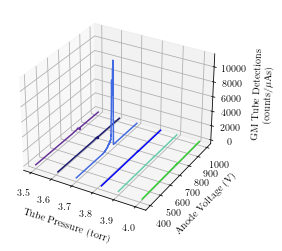

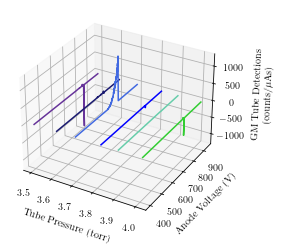

In [4]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')
for p, c in zip([3.5, 3.61, 3.7, 3.82, 3.9, 4.01, 4.11], ['rebeccapurple', 'midnightblue', 'royalblue', 'blue', 'mediumaquamarine', 'limegreen']):
    ax3.plot([p]*len(LGMPlot.loc[p, 400:]), LGMPlot.loc[p, 400:].index.to_list(), LGMPlot.loc[p, 400:].to_list(), c=c)
ax3.set_xlabel('Tube Pressure (torr)')
ax3.set_ylabel('Anode Voltage (V)')
ax3.set_zlabel('\n\n GM Tube Detections \n(counts/$\mu$As)')
plt.savefig('Plots/LGM Waterfall.jpg', dpi=500)

fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d')
for p, c in zip([3.5, 3.61, 3.7, 3.82, 3.9, 4.01, 4.11], ['rebeccapurple', 'midnightblue', 'royalblue', 'blue', 'mediumaquamarine', 'limegreen']):
    ax4.plot([p]*len(RGMPlot.loc[p, 400:]), RGMPlot.loc[p, 400:].index.to_list(), RGMPlot.loc[p, 400:].to_list(), c=c)
ax4.set_xlabel('Tube Pressure (torr)')
ax4.set_ylabel('Anode Voltage (V)')
ax4.set_zlabel('\n\n GM Tube Detections \n(counts/$\mu$As)')
plt.savefig('Plots/RGM Waterfall.jpg', dpi=500)

## VB Plot

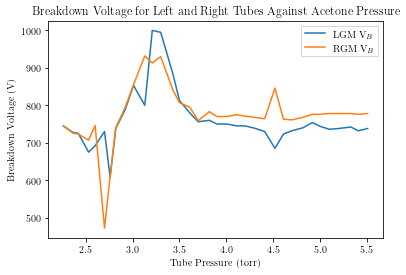

In [5]:
fig5, ax5 = plt.subplots()

ax5.plot(VBPressure, VBL, label='LGM V$_B$')
ax5.plot(VBPressure, VBR, label='RGM V$_B$')
ax5.set_xlabel('Tube Pressure (torr)')
ax5.set_ylabel('Breakdown Voltage (V)')
ax5.legend()
ax5.set_title('Breakdown Voltage for Left and Right Tubes Against Acetone Pressure')
plt.savefig('Plots/VB.jpg', dpi=500)
plt.show()

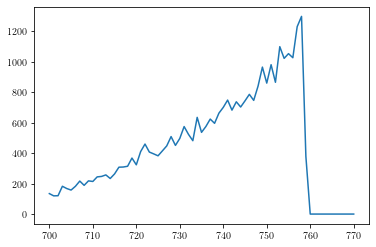

In [6]:
plt.plot(RGMPlot.loc[3.7, 700:770])
plt.show()